In [193]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from analysis_functions import *
from model_functions import *
import matplotlib.patches as patches
import seaborn as sns
import scipy.stats as stats
from scipy.stats import shapiro, chi2, mannwhitneyu, ttest_ind

# Read extraced variables into csv

In [165]:
Vars = pd.read_csv('GCaAMP_MM_extracted_vars.csv')
sensor = 'GCaMP'
#Vars = pd.read_csv('GRAB_MM_extracted_vars.csv')
#sensor = 'GRAB'
Vars

,SessionNumber,SessionBlock,MouseID,EventTime,moveX,moveY,PeakResponse,MinResponse,MeanResponse,MeanResponse_after,MinResponse_after,PeakResponse_after,event
0,session 1,closedloop,B2M5,35.812,0.055712,0.004859,2.114826,-1.342501,0.690253,0.299560,-0.665636,1.789232,no halt
1,session 1,closedloop,B2M5,68.662,0.082007,0.009702,-0.370019,-6.463050,-4.203406,-3.249223,-5.389360,-1.691156,no halt
2,session 1,closedloop,B2M5,86.762,0.042355,0.001521,3.645258,1.714089,2.657278,1.794567,0.806622,2.953353,no halt
3,session 1,closedloop,B2M5,141.892,0.083473,0.010315,1.346915,-3.429003,-1.288684,-1.831975,-3.261274,0.101311,no halt
4,session 1,closedloop,B2M5,165.218,0.048374,0.007258,2.089228,-1.694432,0.715617,0.220824,-1.746632,1.731597,no halt
...,...,...,...,...,...,...,...,...,...,...,...,...,...
704,session 2,openloop,B3M2,1425.272,0.117236,0.012613,2.784993,-0.521463,1.237347,-0.994252,-1.838674,0.154675,halt
705,session 2,openloop,B3M2,1455.689,0.095919,0.011092,0.121090,-2.912162,-1.371198,-1.126389,-3.274219,-0.251507,halt
706,session 2,openloop,B3M2,1790.435,0.123360,0.021138,0.756350,-0.975359,0.073488,0.080203,-0.639360,0.937773,halt
707,session 2,openloop,B3M2,1878.385,0.063050,0.011725,4.459750,1.180627,2.999079,3.179565,2.479217,4.223612,halt


# Make boxplots to view difference in params for halts and no-halts 

In [166]:
halt_data = Vars.loc[Vars.event == 'halt']
halt_data.describe() 

,EventTime,moveX,moveY,PeakResponse,MinResponse,MeanResponse,MeanResponse_after,MinResponse_after,PeakResponse_after
count,271.000000,271.000000,271.000000,271.000000,271.000000,271.000000,270.000000,270.000000,270.000000
mean,871.071727,0.084850,0.008276,1.803608,-1.271660,0.274154,-0.092315,-1.507631,1.451659
std,504.796850,0.055301,0.037692,1.857066,1.399828,1.563949,1.580134,1.590837,1.903358
min,33.536000,-0.008731,-0.552882,-1.873555,-6.926169,-4.914830,-6.643711,-8.288395,-4.114350
25%,467.905000,0.040081,0.003619,0.458492,-1.895109,-0.617351,-0.856918,-2.328360,0.271571
50%,806.201000,0.092897,0.009088,1.538788,-1.115418,0.125052,-0.051599,-1.305856,1.218381
75%,1350.945000,0.118860,0.014251,2.672760,-0.301219,1.122763,0.710005,-0.523620,2.508123
max,1908.957000,0.238479,0.239590,10.529824,3.407252,7.155295,4.872742,3.926176,9.405889


In [167]:
Nohalt_data = Vars.loc[Vars.event == 'no halt']
Nohalt_data.describe() 

,EventTime,moveX,moveY,PeakResponse,MinResponse,MeanResponse,MeanResponse_after,MinResponse_after,PeakResponse_after
count,438.000000,438.000000,438.000000,438.000000,438.000000,438.000000,437.000000,437.000000,437.000000
mean,867.215979,0.090955,0.009507,1.431768,-1.447594,-0.051562,-0.110070,-1.592415,1.513419
std,527.920766,0.058158,0.070387,1.728833,1.388672,1.406819,1.723692,1.544312,2.283177
min,35.812000,-0.061747,-1.106494,-2.936070,-6.818263,-4.203406,-6.625856,-7.949040,-5.150792
25%,464.653000,0.052284,0.004494,0.410277,-2.106378,-0.780857,-0.823544,-2.256849,0.376884
50%,787.479500,0.096984,0.010183,1.209470,-1.260804,-0.004665,-0.124747,-1.399028,1.145589
75%,1340.046000,0.126582,0.015524,2.131350,-0.515179,0.658960,0.608247,-0.703977,2.242387
max,1976.732000,0.293228,0.427453,9.696720,2.745989,5.574811,9.373580,3.980632,12.418234


## Plotting params for individual mice

In [180]:
mouse = 'B3M2'
mousedata = Vars.loc[Vars.MouseID == mouse]
Vars.MouseID.unique()

array(['B2M5', 'B2M4', 'B3M3', 'B3M1', 'B3M2'], dtype=object)

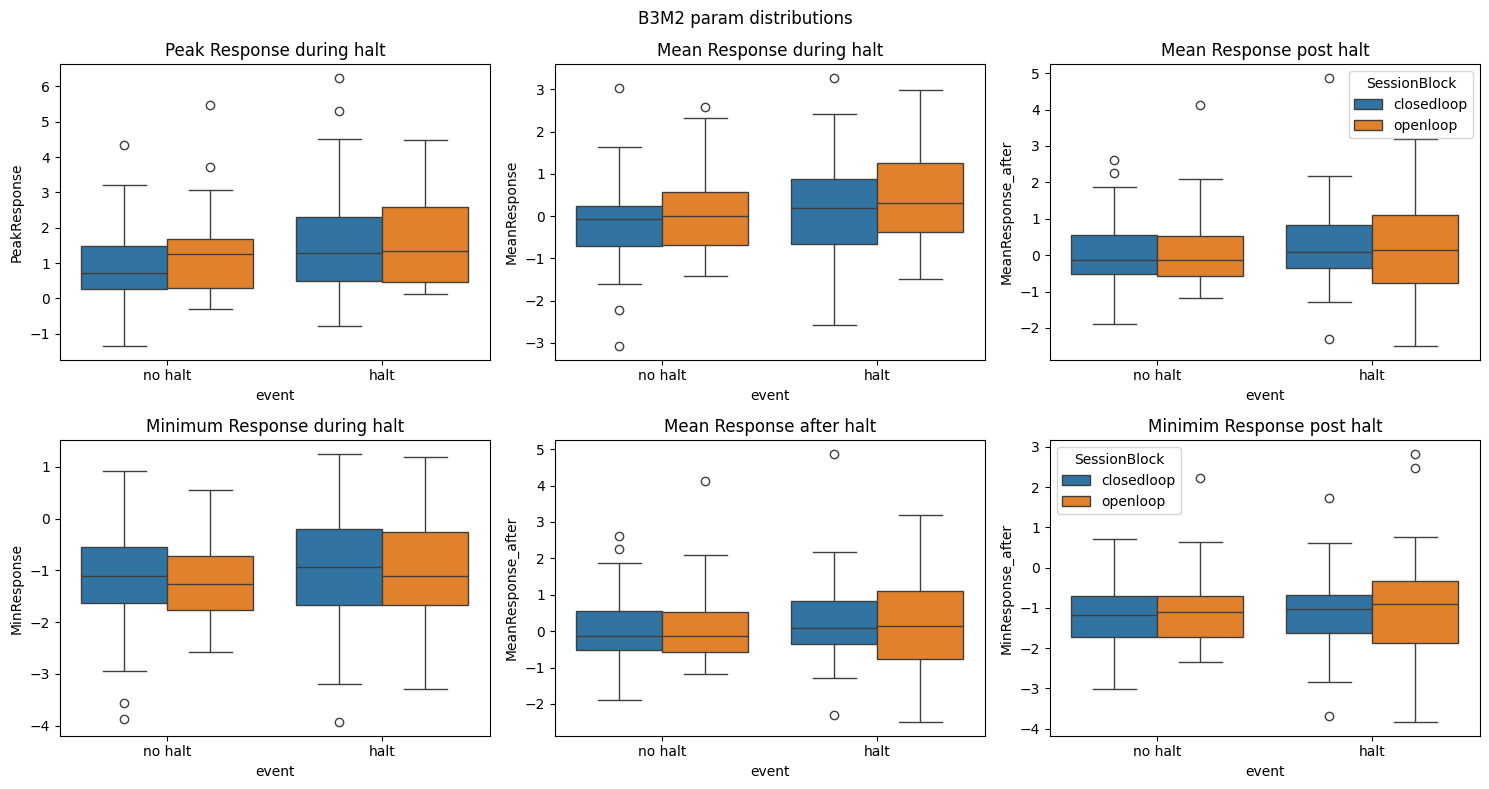

In [181]:
fig, ax = plt.subplots(2,3, figsize = (15, 8))
ax = ax.flatten()
sns.boxplot(x="event", y="PeakResponse", data=mousedata, hue="SessionBlock", ax=ax[0])
ax[0].set_title("Peak Response during halt")
ax[0].get_legend().remove()

sns.boxplot(x="event", y="MeanResponse", data=mousedata, hue="SessionBlock", ax=ax[1])
ax[1].set_title("Mean Response during halt")
ax[1].get_legend().remove()

sns.boxplot(x="event", y="MeanResponse_after", data=mousedata, hue="SessionBlock", ax=ax[2])
ax[2].set_title("Mean Response post halt")


sns.boxplot(x="event", y="MinResponse", data=mousedata, hue="SessionBlock", ax=ax[3])
ax[3].set_title("Minimum Response during halt")
ax[3].get_legend().remove()

sns.boxplot(x="event", y="MeanResponse_after", data=mousedata, hue="SessionBlock", ax=ax[4])
ax[4].set_title("Mean Response after halt")
ax[4].get_legend().remove()

sns.boxplot(x="event", y="MinResponse_after", data=mousedata, hue="SessionBlock", ax=ax[5])
ax[5].set_title("Minimim Response post halt")
fig.suptitle(f'{mouse} param distributions')

fig.tight_layout(pad=1.08)
fig.savefig(f'Figures/{sensor}_{mouse}_halt_nohalt_boxplot.png', format = 'png')

In [200]:
# Grouping by the condition variables and calculating the mean for each group
mouse_means = (
    Vars.groupby(['MouseID', 'event', 'SessionBlock', 'SessionNumber'])
        .agg({
            'PeakResponse': 'mean',
            'PeakResponse_after': 'mean',
            'MeanResponse': 'mean',
            'MeanResponse_after': 'mean',
            'MinResponse_after': 'mean',
            'MinResponse': 'mean'
        })
        .reset_index())


mouse_means.head()

,MouseID,event,SessionBlock,SessionNumber,PeakResponse,PeakResponse_after,MeanResponse,MeanResponse_after,MinResponse_after,MinResponse
0,B2M4,halt,closedloop,session 1,0.949557,0.663263,-0.192758,-0.246236,-1.198441,-1.027173
1,B2M4,halt,closedloop,session 2,1.432897,1.424644,0.318579,0.193463,-1.005347,-0.703753
2,B2M4,halt,openloop,session 1,2.148168,1.329564,0.886788,0.240901,-0.853145,-0.492586
3,B2M4,no halt,closedloop,session 1,1.156758,1.197163,0.031177,0.082250,-0.993389,-0.968435
4,B2M4,no halt,closedloop,session 2,1.037486,0.763611,0.122428,-0.189873,-1.044552,-0.822412


## Plotting all mouse averages togheter

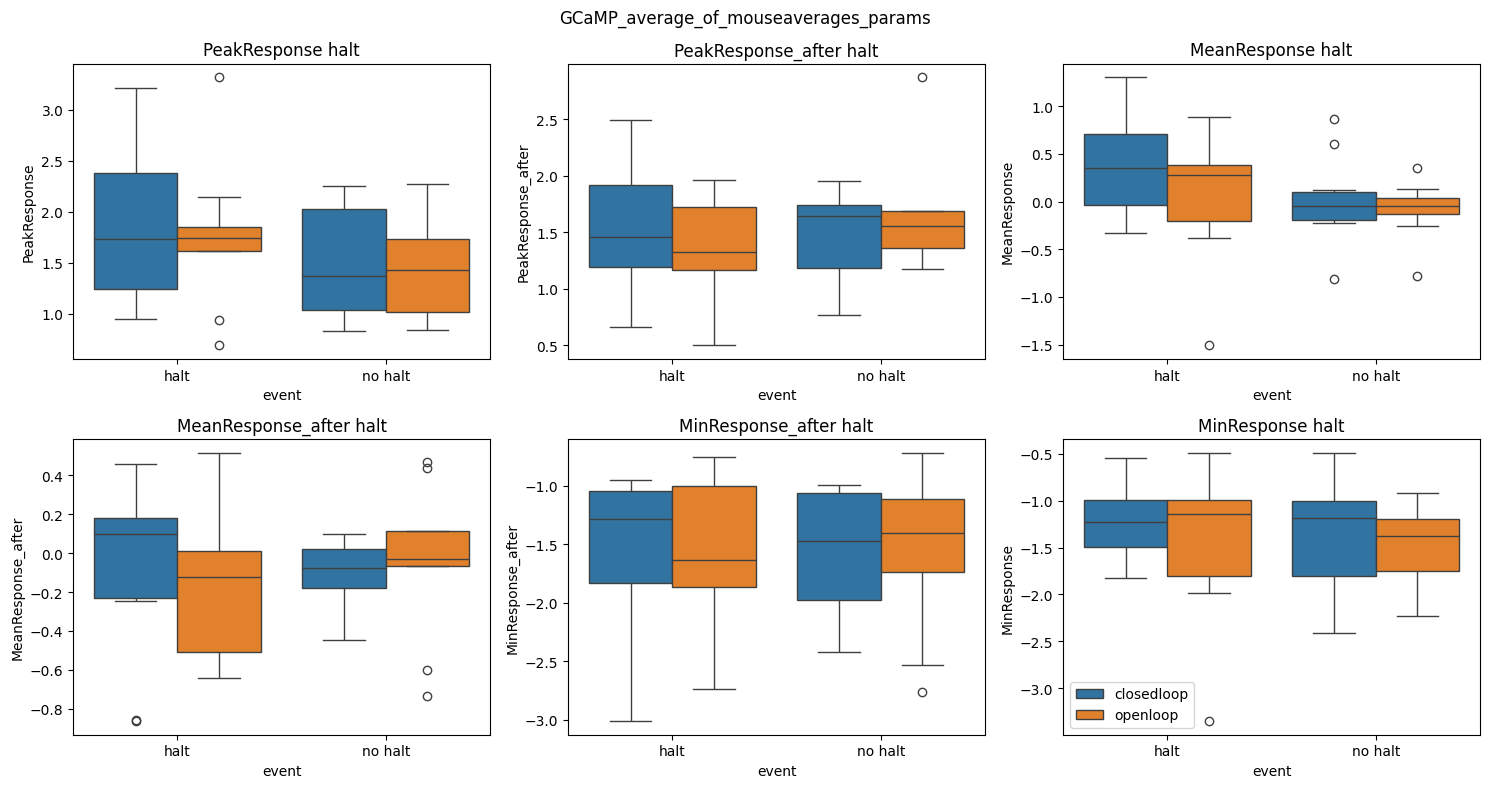

In [206]:
fig, ax = plt.subplots(2,3, figsize = (15, 8))
ax = ax.flatten()

i = 0
for response_col in mouse_means:
    if 'Response' in response_col:
        
        sns.boxplot(x="event", y=response_col, data=mouse_means, hue="SessionBlock", ax=ax[i])
        ax[i].set_title(f"{response_col} halt")
        ax[i].get_legend().remove()
    
        i+=1
plt.legend()
fig.suptitle(f'{sensor}_average_of_mouseaverages_params')

fig.tight_layout(pad=1.08)
fig.savefig(f'Figures/{sensor}_halt_nohalt_boxplot.png', format = 'png')


In [ ]:
## Testing the response difference in the halt and control condition

In [207]:
def testing_diff_control(main_df, control_df):
    #testing normality
    shapiro_main = shapiro(main_df)
    shapiro_control= shapiro(control_df)

    print("Shapiro-Wilk test for halt:", shapiro_main)
    print("Shapiro-Wilk test for no halt:", shapiro_control)

    if (shapiro_main.pvalue < 0.05) or (shapiro_control.pvalue < 0.05):
        print('\n Datasets are normally distributed, will perform t-test \n')
        t_stat, p_val = ttest_ind(main_df, control_df, equal_var=False)
        print(f"T-test: t-statistic={t_stat}, p-value={p_val}")
    else:
        print('\n At least one dataset is not normally distributed, will perform Mann–Whitney U test \n')
        u_stat, p_val = mannwhitneyu(main_df, control_df, alternative='two-sided')
        print(f"Mann-Whitney U test: U-statistic={u_stat}, p-value={p_val}")

    mean_diff = np.mean(main_df) - np.mean(control_df)
    pooled_std = np.sqrt((np.std(main_df, ddof=1)**2 + np.std(control_df, ddof=1)**2) / 2)
    cohens_d = mean_diff / pooled_std
    print(f"Cohen's d: {cohens_d}")

In [208]:
halt_mean_response = mouse_means.loc[mouse_means['event'] == 'halt', 'MeanResponse']
no_halt_mean_response = mouse_means.loc[mouse_means['event'] == 'no halt', 'MeanResponse']

testing_diff_control(halt_mean_response, no_halt_mean_response)

Shapiro-Wilk test for halt: ShapiroResult(statistic=np.float64(0.9430678433978182), pvalue=np.float64(0.2992445824847423))
Shapiro-Wilk test for no halt: ShapiroResult(statistic=np.float64(0.9163908996055667), pvalue=np.float64(0.09706069164347156))

 At least one dataset is not normally distributed, will perform Mann–Whitney U test 

Mann-Whitney U test: U-statistic=241.0, p-value=0.07982801677674653
Cohen's d: 0.4933152975444798


In [210]:
halt_peak_response = mouse_means.loc[mouse_means['event'] == 'halt', 'PeakResponse']
no_peak_mean_response = mouse_means.loc[mouse_means['event'] == 'no halt', 'PeakResponse']

testing_diff_control(halt_peak_response, no_peak_mean_response)

Shapiro-Wilk test for halt: ShapiroResult(statistic=np.float64(0.9352703582382496), pvalue=np.float64(0.21640192773633476))
Shapiro-Wilk test for no halt: ShapiroResult(statistic=np.float64(0.8873186158107463), pvalue=np.float64(0.02885539091837722))

 Datasets are normally distributed, will perform t-test 

T-test: t-statistic=1.7423268862503134, p-value=0.09105073178631214
Cohen's d: 0.5652854871237246


## Fitting Linear Mixed-Effects Model
Response = β0 +β1 ⋅moveX+β2 ⋅moveY+β3 ⋅event+β4 ⋅SessionBlock+β5 ⋅ moveX:SessionBlock+u MouseID + ϵ

In [238]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Fit Linear Mixed-Effects Model
model = smf.mixedlm(
    "MeanResponse ~ moveX + event + SessionBlock + moveX:SessionBlock",
    data=Vars,
    groups=Vars["MouseID"]
)
result = model.fit()
print(result.summary())


                  Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      MeanResponse
No. Observations:      709          Method:                  REML        
No. Groups:            5            Scale:                   2.1436      
Min. group size:       123          Log-Likelihood:          -1275.7950  
Max. group size:       160          Converged:               Yes         
Mean group size:       141.8                                             
-------------------------------------------------------------------------
                               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------
Intercept                       0.508    0.207  2.454 0.014  0.102  0.913
event[T.no halt]               -0.313    0.114 -2.752 0.006 -0.536 -0.090
SessionBlock[T.openloop]       -0.161    0.211 -0.762 0.446 -0.575  0.253
moveX                          -1.904    1.918 -0.993 0.

/Users/hildeteigen/opt/anaconda3/envs/aeon/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/Users/hildeteigen/opt/anaconda3/envs/aeon/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/Users/hildeteigen/opt/anaconda3/envs/aeon/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [236]:
print(Vars["MouseID"].value_counts())
print(Vars.groupby("MouseID")[["moveX", "moveY"]].std())


MouseID
B3M2    160
B3M3    156
B3M1    142
B2M4    128
B2M5    123
Name: count, dtype: int64
            moveX     moveY
MouseID                    
B2M4     0.038303  0.004382
B2M5     0.052174  0.006011
B3M1     0.045799  0.133370
B3M2     0.033707  0.005522
B3M3     0.071230  0.009704


In [239]:
# Fit Linear Mixed-Effects Model
model = smf.mixedlm(
    "PeakResponse ~ moveX + event + SessionBlock + moveX:SessionBlock",
    data=Vars,
    groups=Vars["MouseID"]
)
result = model.fit()
print(result.summary())

                  Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      PeakResponse
No. Observations:      709          Method:                  REML        
No. Groups:            5            Scale:                   3.0510      
Min. group size:       123          Log-Likelihood:          -1404.0320  
Max. group size:       160          Converged:               Yes         
Mean group size:       141.8                                             
-------------------------------------------------------------------------
                               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------
Intercept                       2.100    0.275  7.631 0.000  1.561  2.640
event[T.no halt]               -0.388    0.136 -2.857 0.004 -0.655 -0.122
SessionBlock[T.openloop]       -0.260    0.253 -1.028 0.304 -0.756  0.236
moveX                          -2.629    1.875 -1.402 0.

In [243]:
# Fit Linear Mixed-Effects Model
model = smf.mixedlm(
    "MeanResponse ~ event",
    data=Vars,
    groups=Vars["MouseID"]
)
result = model.fit()
print(result.summary())

           Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: MeanResponse
No. Observations:  709     Method:             REML        
No. Groups:        5       Scale:              2.1539      
Min. group size:   123     Log-Likelihood:     -1280.7675  
Max. group size:   160     Converged:          Yes         
Mean group size:   141.8                                   
-----------------------------------------------------------
                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------
Intercept         0.273    0.094  2.911 0.004  0.089  0.458
event[T.no halt] -0.322    0.114 -2.832 0.005 -0.546 -0.099
Group Var         0.004    0.009                           



/Users/hildeteigen/opt/anaconda3/envs/aeon/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


## Look at halt data alone - especially if significantly different from no halt data

In [244]:
halt_data = Vars.loc[Vars['event'] == 'halt']

In [246]:
# Fit Linear Mixed-Effects Model
model = smf.mixedlm(
    "PeakResponse ~ moveX + SessionBlock + moveX:SessionBlock",
    data=halt_data,
    groups=halt_data["MouseID"]
)
result = model.fit()
print(result.summary())

                  Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      PeakResponse
No. Observations:       271          Method:                  REML        
No. Groups:             5            Scale:                   3.3154      
Min. group size:        48           Log-Likelihood:          -545.0030   
Max. group size:        62           Converged:               Yes         
Mean group size:        54.2                                              
--------------------------------------------------------------------------
                               Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
--------------------------------------------------------------------------
Intercept                       1.710    0.374  4.576 0.000   0.977  2.442
SessionBlock[T.openloop]        0.382    0.423  0.903 0.367  -0.448  1.212
moveX                           1.807    3.235  0.559 0.576  -4.533  8.148
moveX:SessionBlock[T.openloop] -7.930    4.2

In [247]:
#Fit a variable at a time
response_running = smf.ols('MeanResponse ~ moveX + moveX:SessionBlock', data=halt_data).fit()

print(response_running.summary())
#print(response_running.t_test('PeakResponse'))
print("MSE=%.3f" % response_running.mse_resid)

                            OLS Regression Results                            
Dep. Variable:           PeakResponse   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     2.080
Date:                Thu, 12 Dec 2024   Prob (F-statistic):              0.127
Time:                        13:26:05   Log-Likelihood:                -549.69
No. Observations:                 271   AIC:                             1105.
Df Residuals:                     268   BIC:                             1116.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

In [259]:
closedloop_data = halt_data.loc[halt_data.SessionBlock == 'closedloop']

cloop_response_running = smf.ols('MeanResponse ~ moveX', data=closedloop_data).fit()

print(cloop_response_running.summary())
#print(response_running.t_test('PeakResponse'))
print("MSE=%.3f" % response_running.mse_resid)

openloop_data = halt_data.loc[halt_data.SessionBlock == 'openloop']

oloop_response_running = smf.ols('MeanResponse ~ moveX', data=openloop_data).fit()

print(oloop_response_running.summary())
#print(response_running.t_test('PeakResponse'))
print("MSE=%.3f" % response_running.mse_resid)

                            OLS Regression Results                            
Dep. Variable:           MeanResponse   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     1.604
Date:                Thu, 12 Dec 2024   Prob (F-statistic):              0.207
Time:                        13:34:51   Log-Likelihood:                -336.28
No. Observations:                 180   AIC:                             676.6
Df Residuals:                     178   BIC:                             683.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0804      0.262      0.307      0.7

In [277]:
for key, item in {'closedloop': [cloop_response_running, closedloop_data],'openloop': [oloop_response_running, openloop_data] }.items():
    print(item)

[<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x190747980>,     SessionNumber SessionBlock MouseID  EventTime     moveX     moveY  \
438     session 1   closedloop    B2M5    106.104  0.055581  0.004784   
439     session 1   closedloop    B2M5    212.120  0.090729  0.009288   
440     session 1   closedloop    B2M5    313.886  0.103850  0.009088   
441     session 1   closedloop    B2M5    373.535  0.091787  0.011181   
442     session 1   closedloop    B2M5    402.552  0.086683  0.011828   
..            ...          ...     ...        ...       ...       ...   
665     session 2   closedloop    B3M2    720.996  0.120503  0.011156   
666     session 2   closedloop    B3M2    795.395  0.108638  0.015268   
667     session 2   closedloop    B3M2    918.094  0.103326  0.014060   
668     session 2   closedloop    B3M2    946.627  0.131907  0.016937   
669     session 2   closedloop    B3M2    963.610  0.121663  0.015982   

     PeakResponse  MinResponse  Mean

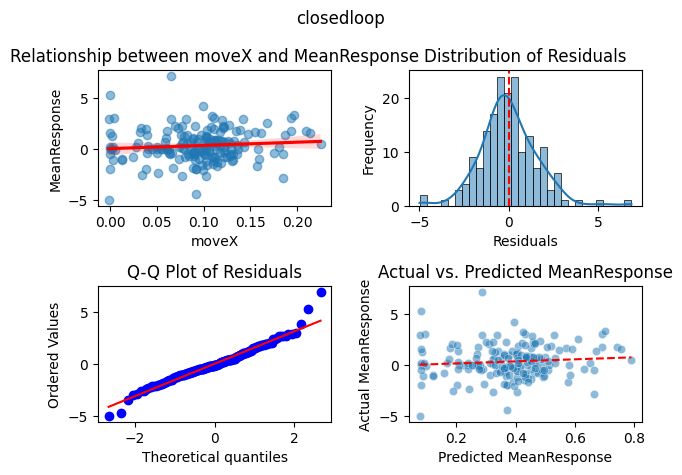

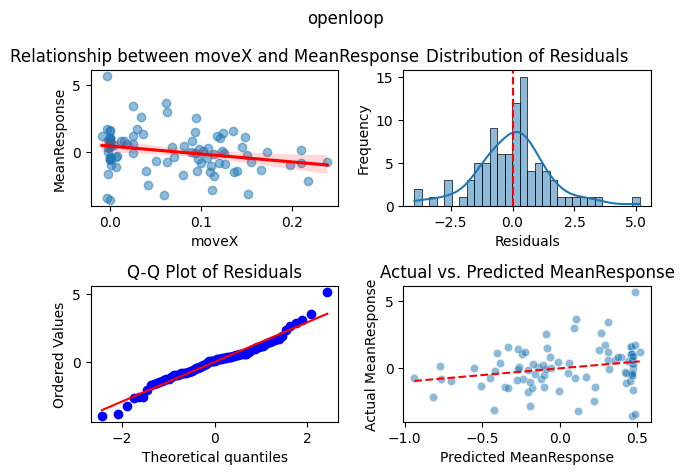

In [281]:
#plotting closed loop
block_result_dict = {'closedloop': [cloop_response_running, closedloop_data],'openloop': [oloop_response_running, openloop_data]}

for block, resultlist in block_result_dict.items():
    
    fig, ax =  plt.subplots(2,2)
    ax = ax.flatten()
    
    residuals = resultlist[0].resid
    sns.regplot(
        x="moveX",
        y="MeanResponse",
        data=resultlist[1],
        line_kws={"color": "red"},
        scatter_kws={"alpha": 0.5}, ax= ax[0])
    ax[0].set_title("Relationship between moveX and MeanResponse")
    ax[0].set_xlabel("moveX")
    ax[0].set_ylabel("MeanResponse")
    
    sns.histplot(residuals, kde=True, bins=30, ax = ax[1])
    ax[1].set_title("Distribution of Residuals")
    ax[1].set_xlabel("Residuals")
    ax[1].set_ylabel("Frequency")
    ax[1].axvline(0, color='red', linestyle='--')
    
    # Q-Q plot
    
    stats.probplot(residuals, dist="norm", plot= ax[2])
    ax[2].set_title("Q-Q Plot of Residuals")
    
    predicted = resultlist[0].params.Intercept + (resultlist[0].params.moveX * resultlist[1]["moveX"])
    
    # Actual vs. predicted plot
    sns.scatterplot(x=predicted, y=resultlist[1]["MeanResponse"], alpha=0.5, ax = ax[3])
    ax[3].plot([min(predicted), max(predicted)], [min(predicted), max(predicted)], color="red", linestyle="--")
    ax[3].set_title("Actual vs. Predicted MeanResponse")
    ax[3].set_xlabel("Predicted MeanResponse")
    ax[3].set_ylabel("Actual MeanResponse")
    
    fig.suptitle(block)
    
    fig.tight_layout()
    


Text(0, 0.5, 'peak response')

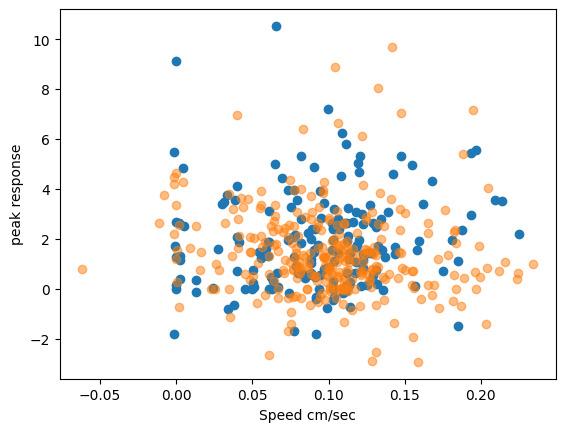

In [234]:
halt_closedloop_data = Vars[(Vars['event'] == 'halt') & (Vars['SessionBlock'] == 'closedloop')]

plt.scatter(halt_closedloop_data['moveX'], halt_closedloop_data['PeakResponse'])

nohalt_closedloop_data = Vars[(Vars['event'] == 'no halt') & (Vars['SessionBlock'] == 'closedloop')]

plt.scatter(nohalt_closedloop_data['moveX'], nohalt_closedloop_data['PeakResponse'], alpha = 0.5)

plt.xlabel('Speed cm/sec')
plt.ylabel('peak response')

In [286]:
# Fit a mixed-effects model
mixed_model = smf.mixedlm(
    "PeakResponse ~ event + SessionNumber + SessionBlock",  # Fixed effects
    data=Vars,
    groups=Vars["MouseID"],  # Random intercept for MouseID
).fit()

print(mixed_model.summary())


                Mixed Linear Model Regression Results
Model:                 MixedLM    Dependent Variable:    PeakResponse
No. Observations:      709        Method:                REML        
No. Groups:            5          Scale:                 3.0551      
Min. group size:       123        Log-Likelihood:        -1408.9420  
Max. group size:       160        Converged:             Yes         
Mean group size:       141.8                                         
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                   1.784    0.213  8.373 0.000  1.367  2.202
event[T.no halt]           -0.398    0.136 -2.925 0.003 -0.665 -0.131
SessionNumber[T.session 2]  0.130    0.133  0.974 0.330 -0.131  0.390
SessionBlock[T.openloop]   -0.099    0.141 -0.702 0.482 -0.376  0.178
Group Var                   0.137   

In [287]:
# Random slopes for 'event' by 'MouseID'
random_slopes_model = smf.mixedlm(
    "PeakResponse ~ event + SessionNumber + SessionBlock",
    data=Vars,
    groups=Vars["MouseID"],
    re_formula="~event"  # Random slope for event within MouseID
).fit()

print(random_slopes_model.summary())

                 Mixed Linear Model Regression Results
Model:                 MixedLM     Dependent Variable:     PeakResponse
No. Observations:      709         Method:                 REML        
No. Groups:            5           Scale:                  3.0523      
Min. group size:       123         Log-Likelihood:         -1408.9129  
Max. group size:       160         Converged:              Yes         
Mean group size:       141.8                                           
-----------------------------------------------------------------------
                             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------
Intercept                     1.784    0.212  8.423 0.000  1.369  2.199
event[T.no halt]             -0.395    0.147 -2.689 0.007 -0.683 -0.107
SessionNumber[T.session 2]    0.132    0.133  0.990 0.322 -0.129  0.393
SessionBlock[T.openloop]     -0.101    0.141 -0.713 0.476 -0.378  0.176
Group Var

In [290]:
null_model = smf.mixedlm(
    "PeakResponse ~ SessionNumber + SessionBlock",
    data=Vars,
    groups=Vars["MouseID"]
).fit()
print(null_model.summary())

                Mixed Linear Model Regression Results
Model:                 MixedLM    Dependent Variable:    PeakResponse
No. Observations:      709        Method:                REML        
No. Groups:            5          Scale:                 3.0885      
Min. group size:       123        Log-Likelihood:        -1412.1245  
Max. group size:       160        Converged:             Yes         
Mean group size:       141.8                                         
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                   1.546    0.195  7.936 0.000  1.164  1.928
SessionNumber[T.session 2]  0.119    0.134  0.891 0.373 -0.143  0.381
SessionBlock[T.openloop]   -0.102    0.142 -0.719 0.472 -0.380  0.176
Group Var                   0.132    0.062                           



In [289]:


# Calculate likelihood ratio
ll_null = null_model.llf  # Log-likelihood of the null model
ll_full = mixed_model.llf  # Log-likelihood of the full model
lr_stat = -2 * (ll_null - ll_full)

# Degrees of freedom
df_diff = mixed_model.df_modelwc - null_model.df_modelwc

# p-value
p_value = chi2.sf(lr_stat, df_diff)

print(f"Likelihood Ratio Test Statistic: {lr_stat}")
print(f"Degrees of Freedom: {df_diff}")
print(f"P-Value: {p_value}")

Likelihood Ratio Test Statistic: 6.364864143484738
Degrees of Freedom: 1
P-Value: 0.011640200711424891


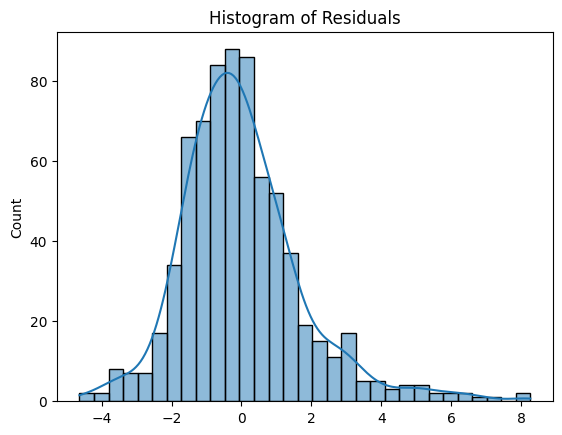

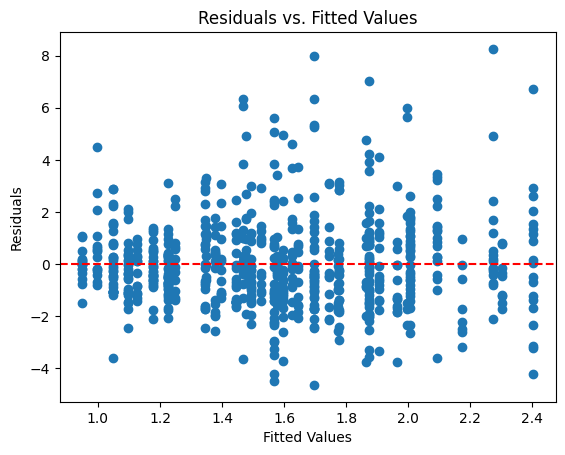

In [293]:
# Extract residuals
residuals = mixed_model.resid

# Histogram of residuals
sns.histplot(residuals, kde=True)
plt.title("Histogram of Residuals")
plt.show()

# Residuals vs. fitted values
fitted_values = mixed_model.fittedvalues
plt.scatter(fitted_values, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs. Fitted Values")
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.show()

In [56]:
# Function to resample and refit the model
import warnings
from sklearn.exceptions import ConvergenceWarning

def bootstrap_coefficients(model, data, n_bootstraps=1000):
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    bootstrap_results = []
    for _ in range(n_bootstraps):
        sample = data.sample(frac=1, replace=True)  # Resample with replacement
        bootstrap_model = smf.mixedlm(
            formula=model.model.formula,
            data=sample,
            groups=sample["MouseID"],
            re_formula="~event"
        ).fit(method='lbfgs', maxiter=100)
        bootstrap_results.append(bootstrap_model.params)
    return pd.DataFrame(bootstrap_results)

# Apply bootstrapping
#bootstrap_results = bootstrap_coefficients(mixed_model, combined_vars)
#print(bootstrap_results.describe())

In [307]:
#Vars.describe()
#bootstrap_results.describe()

In [308]:
interaction_model = smf.mixedlm(
    "PeakResponse ~ event * SessionBlock + SessionNumber",
    data=Vars,
    groups=Vars["MouseID"],
    re_formula="~event"
).fit()

print(interaction_model.summary())

                       Mixed Linear Model Regression Results
Model:                      MixedLM         Dependent Variable:         PeakResponse
No. Observations:           709             Method:                     REML        
No. Groups:                 5               Scale:                      3.0559      
Min. group size:            123             Log-Likelihood:             -1409.1167  
Max. group size:            160             Converged:                  Yes         
Mean group size:            141.8                                                   
------------------------------------------------------------------------------------
                                          Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------------
Intercept                                  1.814    0.220  8.233 0.000  1.382  2.246
event[T.no halt]                          -0.444    0.175 -2.531 0.011 -0.787 -0.100
Sess

In [312]:
nohalt_model = smf.mixedlm(
    "MeanResponse ~ SessionBlock + SessionNumber",
    data=Nohalt_data,
    groups=Nohalt_data["MouseID"]
).fit()

print(nohalt_model.summary())

                Mixed Linear Model Regression Results
Model:                 MixedLM    Dependent Variable:    MeanResponse
No. Observations:      438        Method:                REML        
No. Groups:            5          Scale:                 1.9439      
Min. group size:       62         Log-Likelihood:        -771.2798   
Max. group size:       108        Converged:             Yes         
Mean group size:       87.6                                          
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                  -0.133    0.136 -0.974 0.330 -0.400  0.135
SessionBlock[T.openloop]   -0.065    0.143 -0.458 0.647 -0.345  0.214
SessionNumber[T.session 2]  0.237    0.135  1.757 0.079 -0.027  0.500
Group Var                   0.033    0.025                           



/Users/hildeteigen/opt/anaconda3/envs/aeon/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/hildeteigen/opt/anaconda3/envs/aeon/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(


In [313]:
halt_model = smf.mixedlm(
    "MeanResponse ~ SessionBlock + SessionNumber",
    data=halt_data,
    groups=halt_data["MouseID"]
).fit()

print(halt_model.summary())

                Mixed Linear Model Regression Results
Model:                 MixedLM    Dependent Variable:    MeanResponse
No. Observations:      271        Method:                REML        
No. Groups:            5          Scale:                 2.4072      
Min. group size:       48         Log-Likelihood:        -504.9473   
Max. group size:       62         Converged:             No          
Mean group size:       54.2                                          
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                   0.186    0.150  1.241 0.215 -0.108  0.480
SessionBlock[T.openloop]   -0.277    0.200 -1.387 0.166 -0.670  0.115
SessionNumber[T.session 2]  0.378    0.189  1.996 0.046  0.007  0.748
Group Var                   0.000                                    



/Users/hildeteigen/opt/anaconda3/envs/aeon/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/hildeteigen/opt/anaconda3/envs/aeon/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/Users/hildeteigen/opt/anaconda3/envs/aeon/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/hildeteigen/opt/anaconda3/envs/aeon/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/Users/hildeteigen/opt/anaconda3/envs/aeon/lib/python3.12/site-packages/statsmodels/base/mode